## ch7 Convolution

### 1D convolution

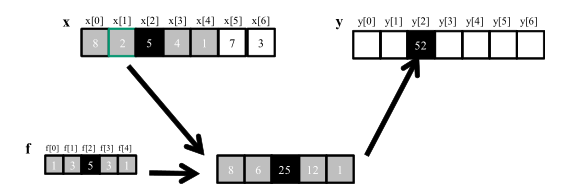

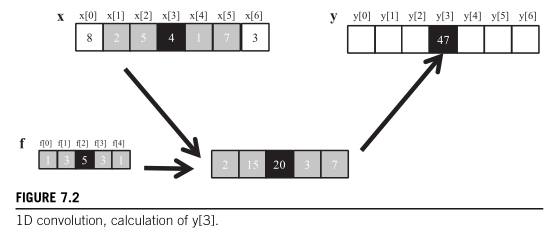


####  boundary condition

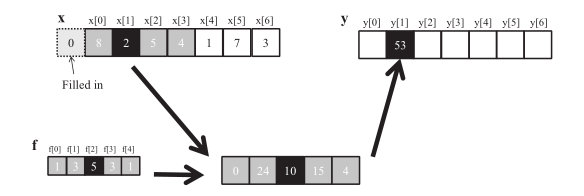

### 2D convolution

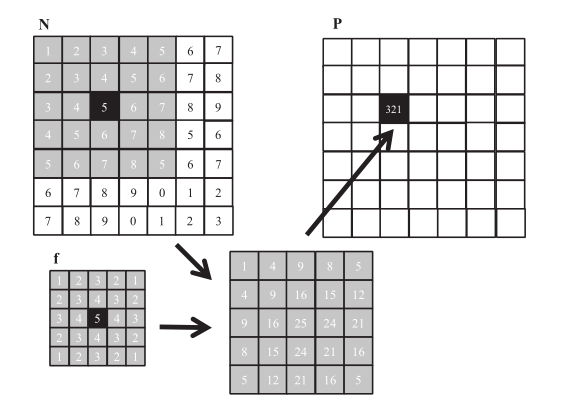

#### boundary condition

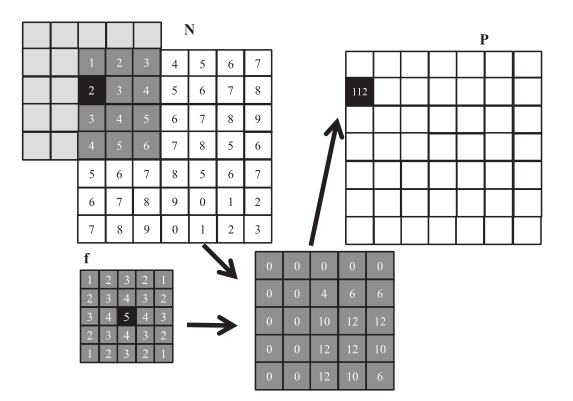

### 7.2 Parallel convolution: a basic implement

- a toy 2D convolution example
- r is filter radium, whereas filter size is 2*r+1

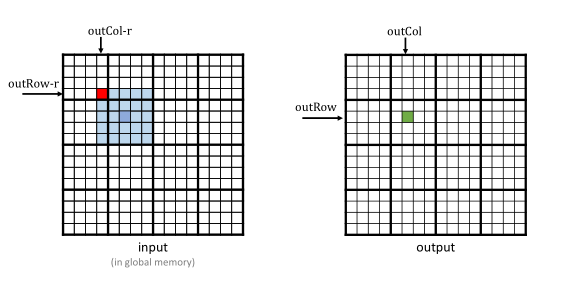

#### A 2D convolution kernel with boundary condition handling
- each thread caculates a output element
- deactivate those threads that beyond the valid output index

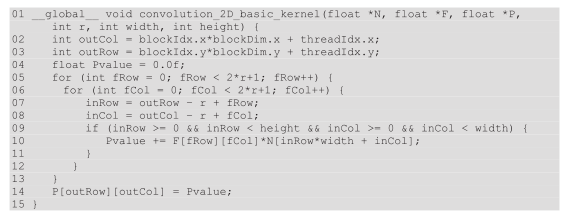

 Threre are two problems or observation on above kernel:
- First, there will be control flow divergence.   
 The threads that calculate the output elements near the four edges of the P array will need to handle ghost cells.  The cost of control divergence will depend on the value of width and height of the input array and the radius of the filter. For large input arrays and small filters, control divergence occurs only in computing a
small portion of the output elements, which will keep the effect of control divergence small. Since convolution is often applied to large images, we expect the effect of control divergence to range from modest to insignificant.     
- A more serious problem is memory bandwidth.  
The ratio of floating-point arithmetic calculation to global memory accesses is only about 0.25 OP/B (2
operations for every 8 bytes loaded on line 10).

### 7.3 Constant memory and caching

There are three interesting properties in the way the filter array F is used in convolution. 
- First, the size of F is typically small.   
the radius of most convolution fil-ters is 7 or smaller. Even in 3D convolution the filter typically contains only less than or equal to 7 3 = 343 elements. 
- Second, the contents of F do not change throughout the execution of the convolution kernel.   
- Third, all threads access the filter elements. Even better, all threads access the F elements in the same order, starting from F[0][0] and moving by one element at a time through the iterations of the doubly nested for-loop in Fig. 7.7.   

These three properties make the filter an excellent candidate for constant memory and caching

####  CUDA memory model.

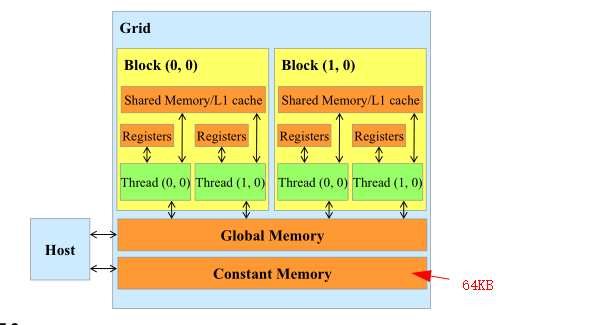

In [ ]:
## store filter data in const memory
#define FILTER_RADIUS 2

# define const memory out of any kernel function
__const__ float F[2*FILTER_RADIUS+1][2*FILTER_RADIUS+1];

# copy host data to const memory
cudaMemcpyToSymbol(F, F_h, (2*FILTER_RADIUS+1)*(2*FILTER_RADIUS+1)*sizeof(float));

#### A 2D convolution kernel using constant memory for F

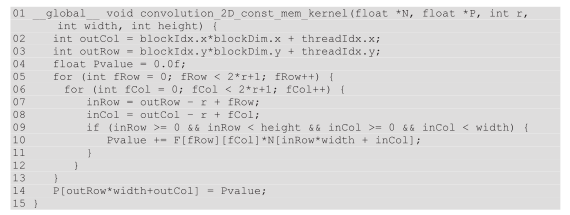

#### caches in cuda

-  caches are “transparent” to programs  
-  in using caches, the program simply accesses the original global memory variables.  
-  modern processors often employ multiple levels of caches.   
The numbering convention for these cache levels reflects the distance to the processor.  
-  L1 cache is small, typically between 16 and 64 KB.  
-  L2 caches are larger, in the range of a few hundred kilobytes to a small number of MBs.  
They are typically shared among multiple processor cores, or streaming multiprocessors (SMs).

The processor hardware will automatically retain the most recently or frequently used variables in the cache and remember their original global memory address. When one of the retained variables is used later, the hardware will detect from their addresses that a copy of the variable is available in cache. The value of the variable will then be served from the cache, eliminating the need to access DRAM.

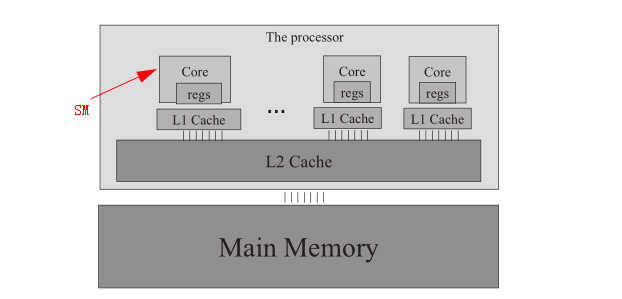

#### constant memory cache
since the constant memory is quite small (64 KB), a small, specialized cache can be highly effective
in capturing the heavily used constant memory variables for each kernel. This specialized cache is called a constant cache in modern GPUs.  
As a result, when all threads in a warp access the same constant memory variable, the constant caches can provide a tremendous amount of bandwidth to satisfy the data needs of these threads. Also, since the size of F is typically small, we can assume that all F elements are effectively always accessed from the constant cache.
Therefore we can simply assume that no DRAM bandwidth is spent on accesses to the F elements. With the use of constant memory and caching, we have effectively doubled the ratio of floating-point arithmetic to memory access to around 0.5 OP/B (2 operations for every 4 bytes loaded on line 10).

### 7.4 Tiled convolution with halo cells

-  in a tiled algorithm, threads collaborate to load input elements into an on-chip memory for subsequent use of these elements.  
-  output tile: collection of output elements processed by each block.  
-  input tile:  collection of input N elements that are needed to calculate the P elements in an output tile.  

#### Input tile versus output tile in a 2D convolution.

- input tiles are larger than the output tiles.
- output tile size x * x, input tile size is (x+2*r) * (x+2*r)

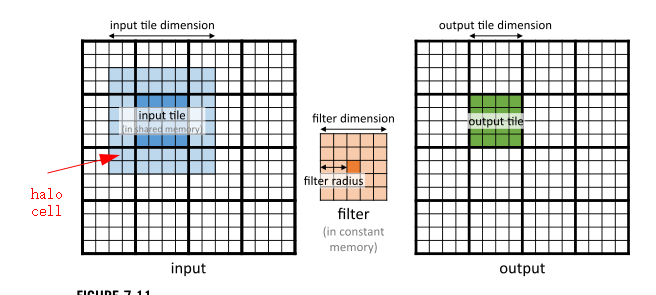

 all threads in a block first collaboratively load the input tile into the shared memory before they calculate the elements of the output tile by accessing the input elements from the shared memory.  
 
 two simple thread organization:
 - block size is same as input tile  
 This simplifies the loading of the input tiles, as each thread needs to load just one input element. However,
since the block dimension is larger than that of the output tile, some of the threads need to be disabled during the calculation of output elements, which can reduce the efficiency of execution resource utilization
 - block size is same as output tile  
  this second strategy makes the input tile loading more complex, as the threads need to iterate to ensure
that all input tile elements are loaded. On the other hand, it simplifies the calculation of the output elements, since the dimension of the block is the same as the output tile, and there is no need to disable any threads during the calculation of output elements.

#### A tiled 2D convolution kernel using constant memory for F

- block size is same as input tile: 32 * 32
- output tile: input tile size subsract 2*r, r=2, (32 - 2*r)*(32 - 2*r)= 28 * 28
- shared memory size is same as input tile   
-  only a subset of the threads in each block will be used to calculate the output tile elements. We use a design that deactivates FILTER_RADIUS exterior layers of threads.  

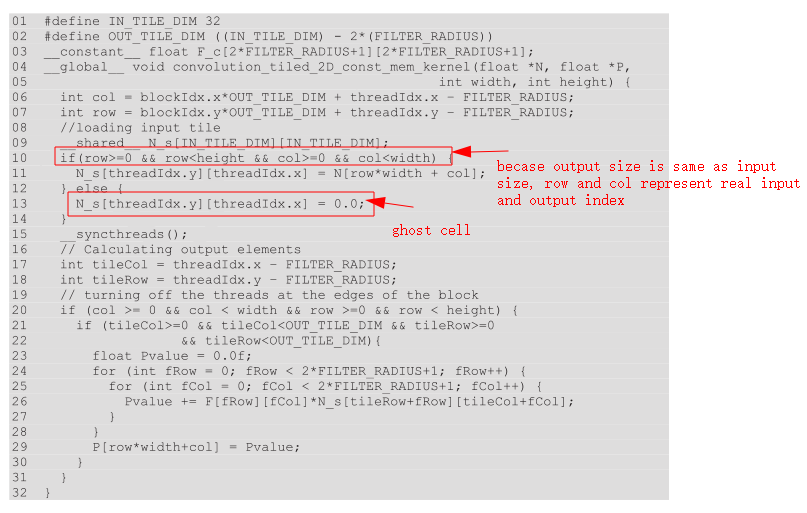

-  a small example of convolution using a 3 x 3 filter ( FILTER_RADIUS =1), 8 x 8 input tiles, 8 x 8 blocks, and 6 x 6 output tiles.  
-  Active thread (tx, ty) will calculate output element (tx - FILTER_RADIUS , ty- FILTER_RADIUS ) using a patch of input tile elements whose upper-left corner is element (tx - FILTER_RADIUS , ty - FILTER_RADIUS ) of the input tile

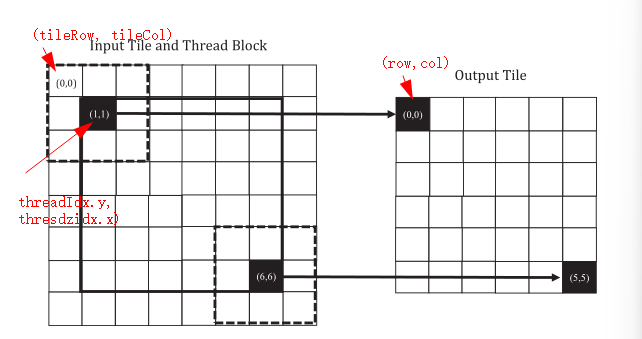

####  arithmetic-to-global memory access ratio

- compute number   
the threadsin an internal block collectively perform OUT_TILE_DIM x OUT_TILE_DIM x (2 x FILTER_RADIUS + 1) x (2 x FILTER_RADIUS + 1) x 2 arithmetic operations. (multiply and add)   
- load memory number   
IN_TILE_DIM x IN_TILE_DIM x 4=(OUT_TILE_DIM+2 x FILTER_RADIUS) x (OUT_TILE_DIM+2 x FILTER_RADIUS) x 4 bytes are loaded by each internal block.   

- arithmetic-to-global memory access ratio for the tiled kernel

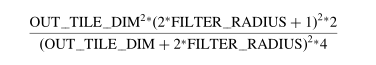


-  upper bound on the arithmetic-to-global memory access ratio    
If OUT_TILE_DIM is much larger than FILTER_RADIUS , we can consider OUT_TILE_DIM+2xFILTER_RADIUS to be approximately OUT_TILE_DIM . This simplifies the expression to (2xFLTER_RADIUS+1)x(2xFLTER_RADIUS+1)x2/4.   


#### Arithmetic-to-global memory access ratio as a function of tile size and filter size

-  The bound on the ratio with a 5 3 5 filter is 12.5 OP/B. However, the ratio that is actually achievable with the 32 x 32 limit on thread block size is 9.57 OP/B.
- For a larger filter, such as 9 x 9, the bound on the ratio is 40.5 OP/B. However, the ratio that is actually achievable with the 32 x 32 limit on thread block size is 22.78 OP/B.

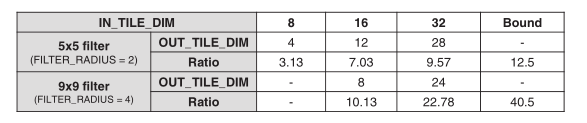

### 7.5 Tiled convolution using caches for halo cells

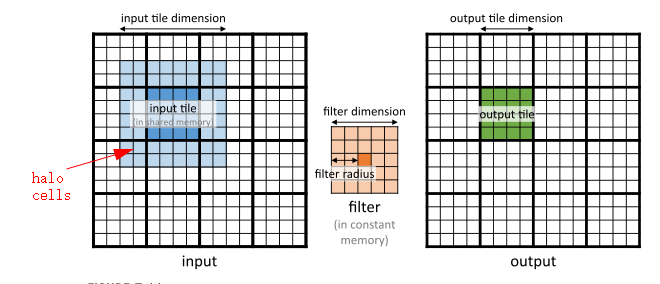

the halo cells of an input tile of a block are also the internal elements of neighboring tiles. For example, in above picture the lightly shaded halo cells of an input tile are also internal elements of the input tiles of neighboring blocks. There is a significant probability that by the time a block needs its halo cells, they are already in L2 cache because of the accesses by its neighboring blocks. As a result, the memory accesses to these halo cells may be naturally served from **L2 cache** without causing additional DRAM traffic.   
That is, we can leave the accesses to these halo cells in the original N elements rather than loading them into the N_ds . 

We now present a tiled convolution algorithm that uses the same dimension for input and output tiles and loads only the internal elements of each tile into the shared memory.

-  the shared memory N_ds array needs to hold only the internal elements of the tile. Thus the input tiles and output tiles are of the same dimension.   

-  the thread blocks can be launched with the same size of the input/output tiles.   

-  each thread can simply load the input element that has the same x and y coordinates as its assigned output element.   

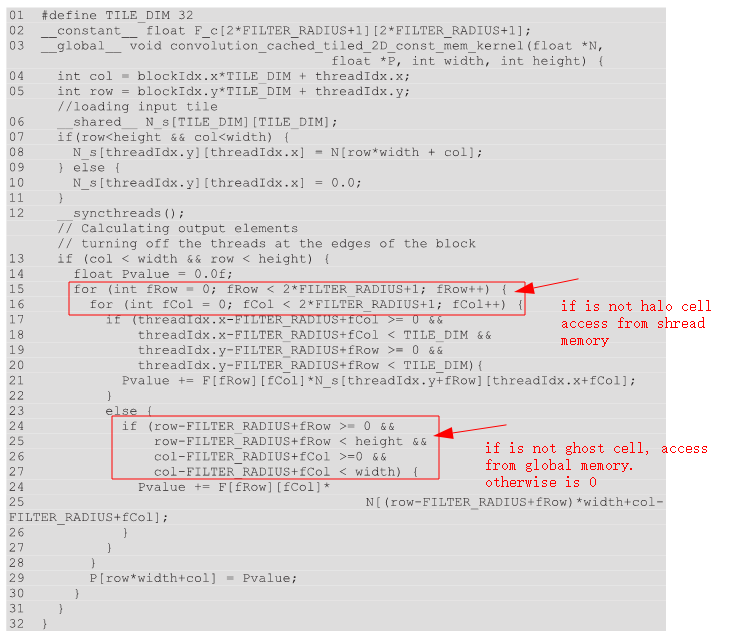